<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/pi/lab7/PI_Laborator_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image augmentation

We start with the necessary imports and set a constant seed for the random number generator in PyTorch.

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
import os
import requests
import zipfile

torch.manual_seed(42);

We will also need the following functions from the previous laboratories:

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    plt.tight_layout()
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [ ]:
def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(url, folder=None):
    """Download and extract a zip file."""
    fname = download(url)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    else:
        assert False, 'Only zip files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In our investigation of common image augmentation methods, we will use the following $400\times 500$ image an example. We also define a function to set the figure size for `matplotlib`.

In [ ]:
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    plt.rcParams['figure.figsize'] = figsize

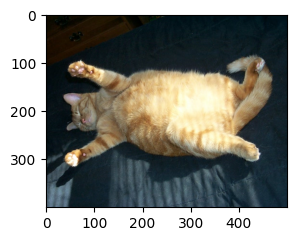

In [ ]:
set_figsize()
img = Image.open('cat1.jpg')
plt.imshow(img);

Most image augmentation methods have a certain degree of randomness. To make it easier for us to observe the effect of image augmentation, next we define an auxiliary function `apply`. This function runs the image augmentation method `aug` multiple times on the input image `img` and shows all the results.

In [ ]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale=scale)

Flipping the image left and right usually does not change the category of the object.
This is one of the earliest and most widely used methods of image augmentation.
Next, we use the `transforms` module to create the `RandomHorizontalFlip` instance, which flips
an image left and right with a 50% chance.

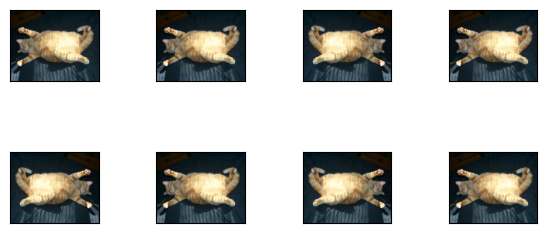

In [ ]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

Flipping up and down is not as common as flipping left and right. But at least for this example image, flipping up and down does not hinder recognition.
Next, we create a `RandomVerticalFlip` instance to flip
an image up and down with a $50\%$ chance.

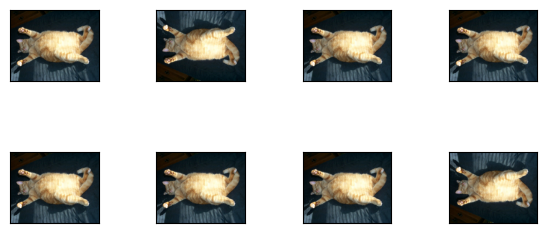

In [ ]:
apply(img, torchvision.transforms.RandomVerticalFlip())

In the example image we used, the cat is in the middle of the image, but this may not be the case in general.
In order to reduce the sensitivity of a convolutional layer to the target position, we can randomly crop the image to make objects appear in different positions in the image at different scales, which can also reduce the sensitivity of a model to the target position.

In the code below, we randomly crop an area with an area of $10\% \sim 100\%$ of the original area each time, and the ratio of width to height of this area is randomly selected from $0.5 \sim 2$. Then, the width and height of the region are both scaled to $200$ pixels.
Unless otherwise specified, the random number between $a$ and $b$ in this section refers to a continuous value obtained by random and uniform sampling from the interval $[a, b]$.

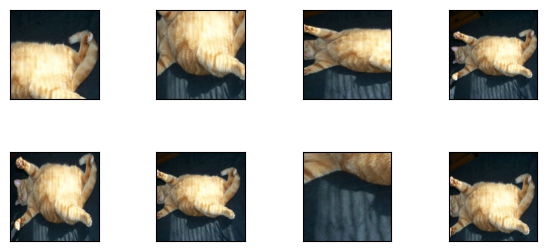

In [ ]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

Another augmentation method is changing colors. We can change four aspects of the image color: brightness, contrast, saturation, and hue. In the example below, we randomly change the brightness of the image to a value between $50\%$ ($1-0.5$) and $150\%$ ($1+0.5$) of the original image.

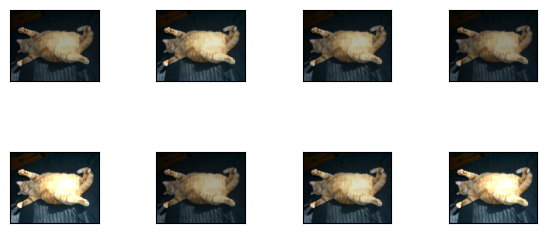

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

Similarly, we can randomly change the hue of the image.

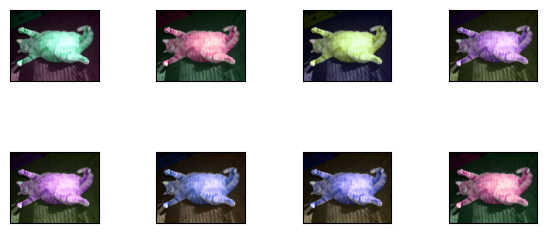

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

We can also create a `ColorJitter` instance and set how to randomly change the `brightness`, `contrast`, `saturation`, and `hue` of the image at the same time.

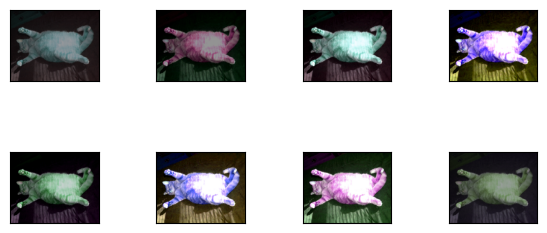

In [ ]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

In practice, we will combine multiple image augmentation methods.
For example,
we can combine the different image augmentation methods defined above and apply them to each image via a `Compose` instance.

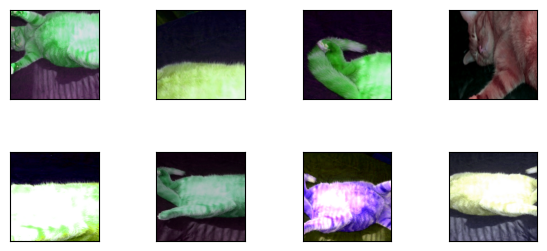

In [ ]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

#Object detection and bounding boxes

We will load the sample image to be used in this section. We can see that there is a dog on the left side of the image and a cat on the right.
They are the two major objects in this image.

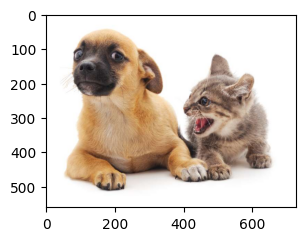

In [ ]:
img = plt.imread('catdog.jpg')
plt.imshow(img);

In object detection,
we usually use a *bounding box* to describe the spatial location of an object.
The bounding box is rectangular, which is determined by the $x$ and $y$ coordinates of the upper-left corner of the rectangle and the such coordinates of the lower-right corner.
Another commonly used bounding box representation is the $(x, y)$-axis
coordinates of the bounding box center, and the width and height of the box.

Here, we define functions to convert between these two representations:
`box_corner_to_center` converts from the two-corner
representation to the center-width-height presentation,
and `box_center_to_corner` vice versa.
The input argument `boxes` should be a two-dimensional tensor of
shape ($n$, 4), where $n$ is the number of bounding boxes.

In [ ]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

We will define the bounding boxes of the dog and the cat in the image based
on the coordinate information.
The origin of the coordinates in the image
is the upper-left corner of the image, and to the right and down are the
positive directions of the $x$ and $y$ axes, respectively.

In [ ]:
# Here `bbox` is the abbreviation for bounding box
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

Let's draw the bounding boxes in the image to check if they are accurate.
Before drawing, we will define a helper function `bbox_to_rect`. It represents the bounding box in the bounding box format of the  `matplotlib` package.

In [ ]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

After adding the bounding boxes on the image,
we can see that the main outline of the two objects are basically inside the two boxes.

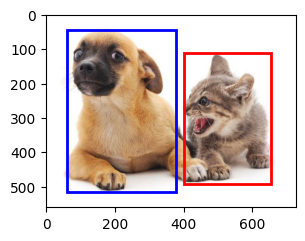

In [ ]:
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

# Anchor boxes

Object detection algorithms usually
sample a large number of regions in the input image, determine whether these regions contain
objects of interest, and adjust the boundaries
of the regions so as to predict the
*ground-truth bounding boxes*
of the objects more accurately.
Different models may adopt
different region sampling schemes.
Here we introduce one of such methods:
it generates multiple bounding boxes with varying scales and aspect ratios centered on each pixel.
These bounding boxes are called *anchor boxes*.

First, let's modify the printing accuracy
just for more concise outputs.

In [ ]:
torch.set_printoptions(2)  # Simplify printing accuracy

Suppose that the input image has a height of $h$ and width of $w$.
We generate anchor boxes with different shapes centered on each pixel of the image.
Let the *scale* be $s\in (0, 1]$ and
the *aspect ratio* (ratio of width to height) is $r > 0$.
Then the width and height of the anchor box are $ws\sqrt{r}$ and $hs/\sqrt{r}$, respectively.
Note that when the center position is given, an anchor box with known width and height is determined.

To generate multiple anchor boxes with different shapes,
let's set a series of scales
$s_1,\ldots, s_n$ and
a series of aspect ratios $r_1,\ldots, r_m$.
When using all the combinations of these scales and aspect ratios with each pixel as the center,
the input image will have a total of $whnm$ anchor boxes. Although these anchor boxes may cover all the
ground-truth bounding boxes, the computational complexity is easily too high.
In practice,
we can only consider those combinations
containing $s_1$ or $r_1$:

$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$

That is to say, the number of anchor boxes centered on the same pixel is $n+m-1$. For the entire input image, we will generate a total of $wh(n+m-1)$ anchor boxes.

The above method of generating anchor boxes is implemented in the following `multibox_prior` function. We specify the input image, a list of scales, and a list of aspect ratios, then this function will return all the anchor boxes.


In [ ]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

We can see that the shape of the returned anchor box variable `Y` is
(batch size, number of anchor boxes, 4).

In [ ]:
img = plt.imread('catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))  # Construct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

After changing the shape of the anchor box variable `Y` to (image height, image width, number of anchor boxes centered on the same pixel, 4),
we can obtain all the anchor boxes centered on a specified pixel position.
In the following,
we access the first anchor box centered on $(250, 250)$. It has four elements: the $(x, y)$-axis coordinates at the upper-left corner and the $(x, y)$-axis coordinates at the lower-right corner of the anchor box.
The coordinate values of both axes
are divided by the width and height of the image, respectively.

In [ ]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

In order to show all the anchor boxes centered on one pixel in the image,
we define the following `show_bboxes` function to draw multiple bounding boxes on the image.

In [ ]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

As we just saw, the coordinate values of the $x$ and $y$ axes in the variable `boxes` have been divided by the width and height of the image, respectively.
When drawing anchor boxes,
we need to restore their original coordinate values;
thus, we define variable `bbox_scale` below.
Now, we can draw all the anchor boxes centered on $(250, 250)$ in the image.
As we can see, the blue anchor box with a scale of $0.75$ and an aspect ratio of $1$ well
surrounds the dog in the image.

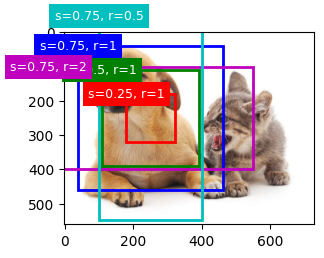

In [ ]:
bbox_scale = torch.tensor((w, h, w, h))
fig = plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

We just mentioned that an anchor box "well" surrounds the dog in the image.
If the ground-truth bounding box of the object is known, how can "well" here be quantified?
Intuitively, we can measure the similarity between
the anchor box and the ground-truth bounding box.
We know that the *Jaccard index* can measure the similarity between two sets. Given sets $\mathcal{A}$ and $\mathcal{B}$, their Jaccard index is the size of their intersection divided by the size of their union:

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$


In fact, we can consider the pixel area of any bounding box as a set of pixels.
In this way, we can measure the similarity of the two bounding boxes by the Jaccard index of their pixel sets. For two bounding boxes, we usually refer their Jaccard index as *intersection over union* (*IoU*), which is the ratio of their intersection area to their union area.
The range of an IoU is between $0$ and $1$:
$0$ means that two bounding boxes do not overlap at all,
while $1$ indicates that the two bounding boxes are equal.

For the remainder of this section, we will use IoU to measure the similarity between anchor boxes and ground-truth bounding boxes, and between different anchor boxes.
Given two lists of anchor or bounding boxes,
the following `box_iou` computes their pairwise IoU
across these two lists.

In [ ]:
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In a training dataset,
we consider each anchor box as a training example.
In order to train an object detection model,
we need *class* and *offset* labels for each anchor box,
where the former is
the class of the object relevant to the anchor box
and the latter is the offset
of the ground-truth bounding box relative to the anchor box.
During the prediction,
for each image
we generate multiple anchor boxes,
predict classes and offsets for all the anchor boxes,
adjust their positions according to the predicted offsets to obtain the predicted bounding boxes,
and finally only output those
predicted bounding boxes that satisfy certain criteria.


As we know, an object detection training set
comes with labels for
locations of *ground-truth bounding boxes*
and classes of their surrounded objects.
To label any generated *anchor box*,
we refer to the labeled
location and class of its *assigned* ground-truth bounding box that is closest to the anchor box.
In the following,
we describe an algorithm for assigning
closest ground-truth bounding boxes to anchor boxes.

Given an image,
suppose that the anchor boxes are $A_1, A_2, \ldots, A_{n_a}$ and the ground-truth bounding boxes are $B_1, B_2, \ldots, B_{n_b}$, where $n_a \geq n_b$.
Let's define a matrix $\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$, whose element $x_{ij}$ in the $i\textrm{th}$ row and $j\textrm{th}$ column is the IoU of the anchor box $A_i$ and the ground-truth bounding box $B_j$. The algorithm consists of the following steps:

1. Find the largest element in matrix $\mathbf{X}$ and denote its row and column indices as $i_1$ and $j_1$, respectively. Then the ground-truth bounding box $B_{j_1}$ is assigned to the anchor box $A_{i_1}$. This is quite intuitive because $A_{i_1}$ and $B_{j_1}$ are the closest among all the pairs of anchor boxes and ground-truth bounding boxes. After the first assignment, discard all the elements in the ${i_1}\textrm{th}$ row and the ${j_1}\textrm{th}$ column in matrix $\mathbf{X}$.
1. Find the largest of the remaining elements in matrix $\mathbf{X}$ and denote its row and column indices as $i_2$ and $j_2$, respectively. We assign ground-truth bounding box $B_{j_2}$ to anchor box $A_{i_2}$ and discard all the elements in the ${i_2}\textrm{th}$ row and the ${j_2}\textrm{th}$ column in matrix $\mathbf{X}$.
1. At this point, elements in two rows and two columns in  matrix $\mathbf{X}$ have been discarded. We proceed until all elements in $n_b$ columns in matrix $\mathbf{X}$ are discarded. At this time, we have assigned a ground-truth bounding box to each of $n_b$ anchor boxes.
1. Only traverse through the remaining $n_a - n_b$ anchor boxes. For example, given any anchor box $A_i$, find the ground-truth bounding box $B_j$ with the largest IoU with $A_i$ throughout the $i\textrm{th}$ row of matrix $\mathbf{X}$, and assign $B_j$ to $A_i$ only if this IoU is greater than a predefined threshold.

This algorithm is implemented in the following `assign_anchor_to_bbox` function.

In [ ]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

Now we can label the class and offset for each anchor box. Suppose that an anchor box $A$ is assigned
a ground-truth bounding box $B$.
On the one hand,
the class of the anchor box $A$ will be
labeled as that of $B$.
On the other hand,
the offset of the anchor box $A$
will be labeled according to the
relative position between
the central coordinates of $B$ and $A$
together with the relative size between
these two boxes.
Given varying
positions and sizes of different boxes in the dataset,
we can apply transformations
to those relative positions and sizes
that may lead to
more uniformly distributed offsets
that are easier to fit.
Here we describe a common transformation.
Given the central coordinates of $A$ and $B$ as $(x_a, y_a)$ and $(x_b, y_b)$,
their widths as $w_a$ and $w_b$,
and their heights as $h_a$ and $h_b$, respectively.
We may label the offset of $A$ as

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$
where default values of the constants are $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$, and $\sigma_w=\sigma_h=0.2$.
This transformation is implemented below in the `offset_boxes` function.

In [ ]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

If an anchor box is not assigned a ground-truth bounding box, we just label the class of the anchor box as "background".
Anchor boxes whose classes are background are often referred to as *negative* anchor boxes,
and the rest are called *positive* anchor boxes.
We implement the following `multibox_target` function
to label classes and offsets for anchor boxes (the `anchors` argument) using ground-truth bounding boxes (the `labels` argument).
This function sets the background class to zero and increments the integer index of a new class by one.

In [ ]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

Let's illustrate anchor box labeling
via a concrete example.
We define ground-truth bounding boxes for the dog and cat in the loaded image,
where the first element is the class ($0$ for dog and $1$ for cat) and the remaining four elements are the
$(x, y)$-axis coordinates
at the upper-left corner and the lower-right corner
(range is between $0$ and $1$).
We also construct five anchor boxes to be labeled
using the coordinates of
the upper-left corner and the lower-right corner:
$A_0, \ldots, A_4$ (the index starts from $0$).
Then we plot these ground-truth bounding boxes
and anchor boxes
in the image.

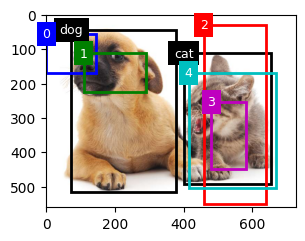

In [ ]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

Using the `multibox_target` function defined above,
we can label classes and offsets
of these anchor boxes based on
the ground-truth bounding boxes for the dog and cat.
In this example, indices of
the background, dog, and cat classes
are $0$, $1$, and $2$, respectively.
Below we add an dimension for examples of anchor boxes and ground-truth bounding boxes.

In [ ]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

There are three items in the returned result, all of which are in the tensor format.
The third item contains the labeled classes of the input anchor boxes.

Let's analyze the returned class labels below based on
anchor box and ground-truth bounding box positions in the image.
First, among all the pairs of anchor boxes
and ground-truth bounding boxes,
the IoU of the anchor box $A_4$ and the ground-truth bounding box of the cat is the largest.
Thus, the class of $A_4$ is labeled as the cat.
Taking out
pairs containing $A_4$ or the ground-truth bounding box of the cat, among the rest
the pair of the anchor box $A_1$ and the ground-truth bounding box of the dog has the largest IoU.
So the class of $A_1$ is labeled as the dog.
Next, we need to traverse through the remaining three unlabeled anchor boxes: $A_0$, $A_2$, and $A_3$.
For $A_0$,
the class of the ground-truth bounding box with the largest IoU is the dog,
but the IoU is below the predefined threshold ($0.5$),
so the class is labeled as background;
for $A_2$,
the class of the ground-truth bounding box with the largest IoU is the cat and the IoU exceeds the threshold, so the class is labeled as the cat;
for $A_3$,
the class of the ground-truth bounding box with the largest IoU is the cat, but the value is below the threshold, so the class is labeled as background.

In [ ]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

The second returned item is a mask variable of the shape (batch size, four times the number of anchor boxes).
Every four elements in the mask variable
correspond to the four offset values of each anchor box.
Since we do not care about background detection,
offsets of this negative class should not affect the objective function.
Through elementwise multiplications, zeros in the mask variable will filter out negative class offsets before calculating the objective function.

In [ ]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

The first returned item contains the four offset values labeled for each anchor box.
Note that the offsets of negative-class anchor boxes are labeled as zeros.

In [ ]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

During prediction,
we generate multiple anchor boxes for the image and predict classes and offsets for each of them.
A *predicted bounding box*
is thus obtained according to
an anchor box with its predicted offset.
Below we implement the `offset_inverse` function
that takes in anchors and
offset predictions as inputs and applies inverse offset transformations to
return the predicted bounding box coordinates.

In [ ]:
def offset_inverse(anchors, offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

When there are many anchor boxes,
many similar (with significant overlap)
predicted bounding boxes
can be potentially output for surrounding the same object.
To simplify the output,
we can merge similar predicted bounding boxes
that belong to the same object
by using *non-maximum suppression* (NMS).

Here is how non-maximum suppression works.
For a predicted bounding box $B$,
the object detection model calculates the predicted likelihood
for each class.
Denoting by $p$ the largest predicted likelihood,
the class corresponding to this probability is the predicted class for $B$.
Specifically, we refer to $p$ as the *confidence* (score) of the predicted bounding box $B$.
On the same image,
all the predicted non-background bounding boxes
are sorted by confidence in descending order
to generate a list $L$.
Then we manipulate the sorted list $L$ in the following steps:

1. Select the predicted bounding box $B_1$ with the highest confidence from $L$ as a basis and remove all non-basis predicted bounding boxes whose IoU with $B_1$ exceeds a predefined threshold $\epsilon$ from $L$. At this point, $L$ keeps the predicted bounding box with the highest confidence but drops others that are too similar to it. In a nutshell, those with *non-maximum* confidence scores are *suppressed*.
1. Select the predicted bounding box $B_2$ with the second highest confidence from $L$ as another basis and remove all non-basis predicted bounding boxes whose IoU with $B_2$ exceeds $\epsilon$ from $L$.
1. Repeat the above process until all the predicted bounding boxes in $L$ have been used as a basis. At this time, the IoU of any pair of predicted bounding boxes in $L$ is below the threshold $\epsilon$; thus, no pair is too similar with each other.
1. Output all the predicted bounding boxes in the list $L$.

The following `nms` function sorts confidence scores in descending order and returns their indices.

In [ ]:
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

We define the following `multibox_detection`
to apply non-maximum suppression
to predicting bounding boxes.

In [ ]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        # Find all non-`keep` indices and set the class to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

Now let's apply the above implementations
to a concrete example with four anchor boxes.
For simplicity, we assume that the
predicted offsets are all zeros.
This means that the predicted bounding boxes are anchor boxes.
For each class among the background, dog, and cat,
we also define its predicted likelihood.

In [ ]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # Predicted background likelihood
                      [0.9, 0.8, 0.7, 0.1],  # Predicted dog likelihood
                      [0.1, 0.2, 0.3, 0.9]])  # Predicted cat likelihood

We can plot these predicted bounding boxes with their confidence on the image.

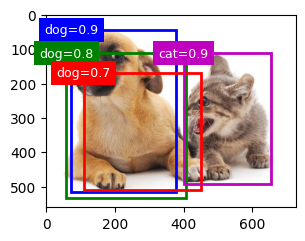

In [ ]:
fig = plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

Now we can invoke the `multibox_detection` function
to perform non-maximum suppression,
where the threshold is set to $0.5$.
Note that we add
a dimension for examples in the tensor input.

We can see that the shape of the returned result is
(batch size, number of anchor boxes, 6).
The six elements in the innermost dimension
gives the output information for the same predicted bounding box.
The first element is the predicted class index, which starts from $0$ ($0$ is dog and $1$ is cat). The value $-1$ indicates background or removal in non-maximum suppression.
The second element is the confidence of the predicted bounding box.
The remaining four elements are the $(x, y)$-axis coordinates of the upper-left corner and
the lower-right corner of the predicted bounding box, respectively (range is between $0$ and $1$).

In [ ]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

After removing those predicted bounding boxes
of class $-1$,
we can output the final predicted bounding box
kept by non-maximum suppression.

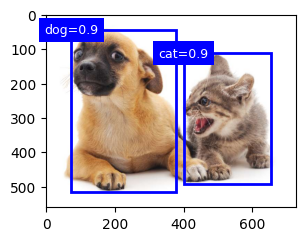

In [ ]:
fig = plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

In practice, we can remove predicted bounding boxes with lower confidence even before performing non-maximum suppression, thereby reducing computation in this algorithm.
We may also post-process the output of non-maximum suppression, for example, by only keeping
results with higher confidence
in the final output.

# Multiscale object detection

In the previous section,
we generated multiple anchor boxes centered on each pixel of an input image.
Essentially these anchor boxes
represent samples of
different regions of the image.
However,
we may end up with too many anchor boxes to compute
if they are generated for *every* pixel.
Think of a $561 \times 728$ input image.
If five anchor boxes
with varying shapes
are generated for each pixel as their center,
over two million anchor boxes ($561 \times 728 \times 5$) need to be labeled and predicted on the image.

It is not difficult to reduce anchor boxes on an image.
For instance, we can just
uniformly sample a small portion of pixels
from the input image
to generate anchor boxes centered on them.
In addition,
at different scales
we can generate different numbers of anchor boxes
of different sizes.
Intuitively,
smaller objects are more likely
to appear on an image than larger ones.
As an example,
$1 \times 1$, $1 \times 2$, and $2 \times 2$ objects
can appear on a $2 \times 2$ image
in $4$, $2$, and $1$ possible ways, respectively.
Therefore, when using smaller anchor boxes to detect smaller objects, we can sample more regions,
while for larger objects we can sample fewer regions.

To demonstrate how to generate anchor boxes
at multiple scales, let's read an image.
Its height and width are $561$ and $728$ pixels, respectively.

In [ ]:
img = plt.imread('catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

Recall that we call a two-dimensional array output of
a convolutional layer a feature map.
By defining the feature map shape,
we can determine centers of uniformly sampled anchor boxes  on any image.

The `display_anchors` function is defined below.
We generate anchor boxes (`anchors`) on the feature map (`fmap`) with each unit (pixel) as the anchor box center.
Since the $(x, y)$-axis coordinate values
in the anchor boxes (`anchors`) have been divided by the width and height of the feature map (`fmap`),
these values are between $0$ and $1$,
which indicate the relative positions of
anchor boxes in the feature map.

Since centers of the anchor boxes (`anchors`)
are spread over all units on the feature map (`fmap`),
these centers must be *uniformly* distributed
on any input image
in terms of their relative spatial positions.
More concretely,
given the width and height of the feature map `fmap_w` and `fmap_h`, respectively,
the following function will *uniformly* sample
pixels in `fmap_h` rows and `fmap_w` columns
on any input image.
Centered on these uniformly sampled pixels,
anchor boxes of scale `s` (assuming the length of the list `s` is $1$) and different aspect ratios (`ratios`)
will be generated.

In [ ]:
def display_anchors(fmap_w, fmap_h, s):
    # Values on the first two dimensions do not affect the output
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    show_bboxes(plt.imshow(img).axes,
                anchors[0] * bbox_scale)

First, let's consider
detection of small objects.
In order to make it easier to distinguish when displayed, the anchor boxes with different centers here do not overlap:
the anchor box scale is set to $0.15$
and the height and width of the feature map are set to $4$. We can see
that the centers of the anchor boxes in $4$ rows and $4$ columns on the image are uniformly distributed.

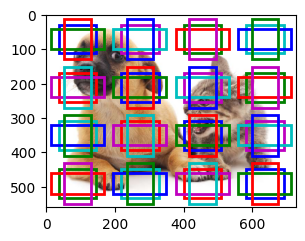

In [ ]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

We move on to reduce the height and width of the feature map by half and use larger anchor boxes to detect larger objects. When the scale is set to $0.4$,
some anchor boxes will overlap with each other.

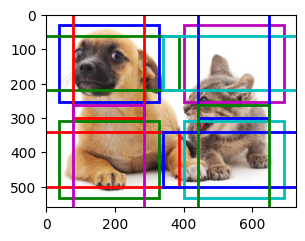

In [ ]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

Finally, we further reduce the height and width of the feature map by half and increase the anchor box scale to $0.8$. Now the center of the anchor box is the center of the image.

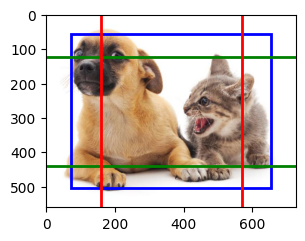

In [ ]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

# The object detection dataset


There is no small dataset such as MNIST and Fashion-MNIST in the field of object detection.
In order to quickly demonstrate object detection models,
we use a small dataset.
First, $1000$ banana images with different rotations and sizes were generated.
Then each banana image was placed
at a random position on some background image.
In the end, bounding boxes for those bananas on the images were labeled.

The banana detection dataset with all the image and
csv label files can be downloaded directly from the Internet.

In [ ]:
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    data_dir = download_extract('http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

By using the `read_data_bananas` function to read images and labels,
the following `BananasDataset` class
will allow us to create a customized `Dataset` instance
for loading the banana detection dataset.

In [ ]:
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

Finally, we define
the `load_data_bananas` function to return two
data iterator instances for both the training and test sets.
For the test dataset,
there is no need to read it in random order.

In [ ]:
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

Let's read a minibatch and print the shapes of
both images and labels in this minibatch.
The shape of the image minibatch,
(batch size, number of channels, height, width),
looks familiar:
it is the same as in our earlier image classification tasks.
The shape of the label minibatch is
(batch size, $m$, $5$),
where $m$ is the largest possible number of bounding boxes
that any image has in the dataset.

Although computation in minibatches is more efficient,
it requires that all the image examples
contain the same number of bounding boxes to form a minibatch via concatenation.
In general,
images may have a varying number of bounding boxes;
thus,
images with fewer than $m$ bounding boxes
will be padded with illegal bounding boxes
until $m$ is reached.
Then
the label of each bounding box is represented by an array of length $5$.
The first element in the array is the class of the object in the bounding box,
where $-1$ indicates an illegal bounding box for padding.
The remaining four elements of the array are
the ($x$, $y$)-coordinate values
of the upper-left corner and the lower-right corner
of the bounding box (the range is between $0$ and $1$).
For the banana dataset,
since there is only one bounding box on each image,
we have $m=1$.

In [ ]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

Let's demonstrate ten images with their labeled ground-truth bounding boxes. We can see that the rotations, sizes, and positions of bananas vary across all these images. Of course, this is just a simple artificial dataset. In practice, real-world datasets are usually much more complicated.

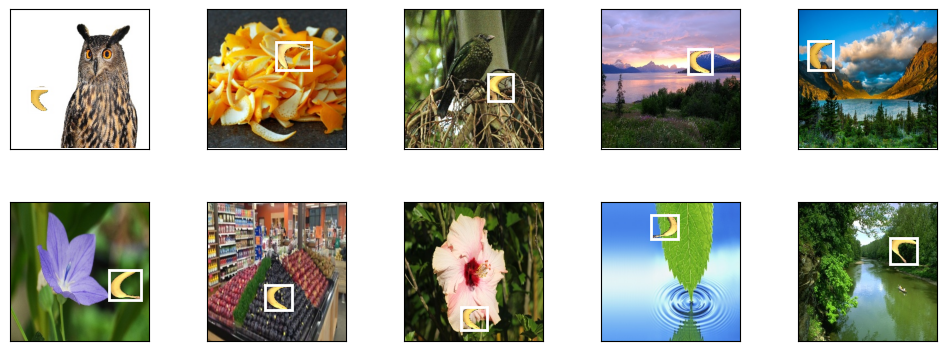

In [ ]:
imgs = (batch[0][:10].permute(0, 2, 3, 1)) / 255
axes = show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

# Single shot multibox detection

In the previous sections,
we introduced bounding boxes, anchor boxes,
multiscale object detection, and the dataset for object detection.
Now we are ready to use such background
knowledge to design an object detection model:
*single shot multibox detection*
(*SSD*).
This model is simple, fast, and widely used.
Although this is just one of vast amounts of
object detection models,
some of the design principles
and implementation details in this section
are also applicable to other models.

This model mainly consists of
a base network
followed by
several multiscale feature map blocks.
The base network
is for extracting features from the input image,
so it can use a deep CNN.
For example,
the original single-shot multibox detection paper
adopts a VGG network truncated before the
classification layer,
while ResNet has also been commonly used.
Through our design
we can make the base network output
larger feature maps
so as to generate more anchor boxes
for detecting smaller objects.
Subsequently,
each multiscale feature map block
reduces (e.g., by half)
the height and width of the feature maps
from the previous block,
and enables each unit
of the feature maps
to increase its receptive field on the input image.


Recall the design
of multiscale object detection
through layerwise representations of images by
deep neural networks.
Since
multiscale feature maps closer to the top
are smaller but have larger receptive fields,
they are suitable for detecting
fewer but larger objects.

In a nutshell,
via its base network and several multiscale feature map blocks,
single-shot multibox detection
generates a varying number of anchor boxes with different sizes,
and detects varying-size objects
by predicting classes and offsets
of these anchor boxes (thus the bounding boxes);
thus, this is a multiscale object detection model.

In the following,
we will describe the implementation details
of different blocks in the model. To begin with, we discuss how to implement
the class and bounding box prediction.

Let the number of object classes be $q$.
Then anchor boxes have $q+1$ classes,
where class $0$ is background.
At some scale,
suppose that the height and width of feature maps
are $h$ and $w$, respectively.
When $a$ anchor boxes
are generated with
each spatial position of these feature maps as their center,
a total of $hwa$ anchor boxes need to be classified.
This often makes classification with fully connected layers infeasible due to likely
heavy parametrization costs.
Single-shot multibox detection uses channels of convolutional layers
to predict classes to reduce model complexity.

Specifically,
the class prediction layer uses a convolutional layer
without altering width or height of feature maps.
In this way,
there can be a one-to-one correspondence
between outputs and inputs
at the same spatial dimensions (width and height)
of feature maps.
More concretely,
channels of the output feature maps
at any spatial position ($x$, $y$)
represent class predictions
for all the anchor boxes centered on
($x$, $y$) of the input feature maps.
To produce valid predictions,
there must be $a(q+1)$ output channels,
where for the same spatial position
the output channel with index $i(q+1) + j$
represents the prediction of
the class $j$ ($0 \leq j \leq q$)
for the anchor box $i$ ($0 \leq i < a$).

Below we define such a class prediction layer,
specifying $a$ and $q$ via arguments `num_anchors` and `num_classes`, respectively.
This layer uses a $3\times3$ convolutional layer with a
padding of $1$.
The width and height of the input and output of this
convolutional layer remain unchanged.

In [ ]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

The design of the bounding box prediction layer is similar to that of the class prediction layer.
The only difference lies in the number of outputs for each anchor box:
here we need to predict four offsets rather than $q+1$ classes.

In [ ]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

As we mentioned, single-shot multibox detection
uses multiscale feature maps to generate anchor boxes and predict their classes and offsets.
At different scales,
the shapes of feature maps
or the numbers of anchor boxes centered on the same unit
may vary.
Therefore,
shapes of the prediction outputs
at different scales may vary.

In the following example,
we construct feature maps at two different scales,
`Y1` and `Y2`,
for the same minibatch,
where the height and width of `Y2`
are half of those of `Y1`.
Let's take class prediction as an example.
Suppose that
$5$ and $3$ anchor boxes
are generated for every unit in `Y1` and `Y2`, respectively.
Suppose further that
the number of object classes is $10$.
For feature maps `Y1` and `Y2`
the numbers of channels in the class prediction outputs
are $5\times(10+1)=55$ and $3\times(10+1)=33$, respectively,
where either output shape is
(batch size, number of channels, height, width).

In [ ]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

As we can see, except for the batch size dimension,
the other three dimensions all have different sizes.
To concatenate these two prediction outputs for more efficient computation,
we will transform these tensors into a more consistent format.

Note that
the channel dimension holds the predictions for
anchor boxes with the same center.
We first move this dimension to the innermost.
Since the batch size remains the same for different scales,
we can transform the prediction output
into a two-dimensional tensor
with shape (batch size, height $\times$ width $\times$ number of channels).
Then we can concatenate
such outputs at different scales
along dimension $1$.

In [ ]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In this way,
even though `Y1` and `Y2` have different sizes
in channels, heights, and widths,
we can still concatenate these two prediction outputs at two different scales for the same minibatch.

In [ ]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In order to detect objects at multiple scales,
we define the following downsampling block `down_sample_blk` that
halves the height and width of input feature maps.
In fact,
this block applies the design of VGG blocks.
More concretely,
each downsampling block consists of
two $3\times3$ convolutional layers with padding of $1$
followed by a $2\times2$ max-pooling layer with stride of $2$.
As we know, $3\times3$ convolutional layers with padding of $1$ do not change the shape of feature maps.
However, the subsequent $2\times2$ max-pooling  reduces the height and width of input feature maps by half.
For both input and output feature maps of this downsampling block,
because $1\times 2+(3-1)+(3-1)=6$,
each unit in the output
has a $6\times6$ receptive field on the input.
Therefore, the downsampling block enlarges the receptive field of each unit in its output feature maps.

In [ ]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In the following example, our constructed downsampling block changes the number of input channels and halves the height and width of the input feature maps.

In [ ]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

The base network block is used to extract features from input images.
For simplicity,
we construct a small base network
consisting of three downsampling blocks
that double the number of channels at each block.
Given a $256\times256$ input image,
this base network block outputs $32 \times 32$ feature maps ($256/2^3=32$).

In [ ]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

The complete
single shot multibox detection model
consists of five blocks.
The feature maps produced by each block
are used for both
(i) generating anchor boxes
and (ii) predicting classes and offsets of these anchor boxes.
Among these five blocks,
the first one
is the base network block,
the second to the fourth are
downsampling blocks,
and the last block
uses global max-pooling
to reduce both the height and width to $1$.
Technically,
the second to the fifth blocks
are all
those
multiscale feature map blocks
in the model.

In [ ]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

Now we define the forward propagation
for each block.
Different from
in image classification tasks,
outputs here include
(i) CNN feature maps `Y`,
(ii) anchor boxes generated using `Y` at the current scale,
and (iii) classes and offsets predicted (based on `Y`)
for these anchor boxes.

In [ ]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

Recall that
in the model,
a multiscale feature map block
that is closer to the top
is for detecting larger objects;
thus, it needs to generate larger anchor boxes.
In the above forward propagation,
at each multiscale feature map block
we pass in a list of two scale values
via the `sizes` argument
of the invoked `multibox_prior` function.
In the following,
the interval between $0.2$ and $1.05$
is split evenly
into five sections to determine the
smaller scale values at the five blocks: $0.2$, $0.37$, $0.54$, $0.71$, and $0.88$.
Then their larger scale values
are given by
$\sqrt{0.2 \times 0.37} = 0.272$, $\sqrt{0.37 \times 0.54} = 0.447$, and so on.

In [ ]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

Now we can define the complete model `TinySSD` as follows.

In [ ]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

We create a model instance
and use it to perform forward propagation on a minibatch of $256 \times 256$ images `X`.

As shown earlier in this section,
the first block outputs $32 \times 32$ feature maps.
Recall that
the second to fourth downsampling blocks
halve the height and width
and the fifth block uses global pooling.
Since $4$ anchor boxes
are generated for each unit along spatial dimensions
of feature maps,
at all the five scales
a total of $(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$ anchor boxes are generated for each image.

In [ ]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


Now we will explain
how to train the single shot multibox detection model
for object detection.

To begin with,
let's read
the banana detection dataset
described before.

In [ ]:
batch_size = 32
train_iter, _ = load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


There is only one class in the banana detection dataset. After defining the model,
we need to initialize its parameters and define
the optimization algorithm.

In [ ]:
device, net = try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

Object detection has two types of losses.
The first loss concerns classes of anchor boxes:
its computation
can simply reuse
the cross-entropy loss function
that we used for image classification.
The second loss
concerns offsets of positive (non-background) anchor boxes:
this is a regression problem.
For this regression problem,
however,
here we do not use the squared loss.
Instead,
we use the $\ell_1$ norm loss,
the absolute value of the difference between
the prediction and the ground-truth.
The mask variable `bbox_masks` filters out
negative anchor boxes and illegal (padded)
anchor boxes in the loss calculation.
In the end, we sum up
the anchor box class loss
and the anchor box offset loss
to obtain the loss function for the model.

In [ ]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

We can use accuracy to evaluate the classification results.
Due to the used $\ell_1$ norm loss for the offsets,
we use the *mean absolute error* to evaluate the
predicted bounding boxes.
These prediction results are obtained
from the generated anchor boxes and the
predicted offsets for them.

In [ ]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

When training the model,
we need to generate multiscale anchor boxes (`anchors`)
and predict their classes (`cls_preds`) and offsets (`bbox_preds`) in the forward propagation.
Then we label the classes (`cls_labels`) and offsets (`bbox_labels`) of such generated anchor boxes
based on the label information `Y`.
Finally, we calculate the loss function
using the predicted and labeled values
of the classes and offsets.
For concise implementations,
evaluation of the test dataset is omitted here.

In [ ]:
def train(net, train_iter, num_epochs, device):
  cls_acc_all = []
  bbox_mae_all = []
  net = net.to(device)
  for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    total_cls = 0
    total_cls_labels = 0
    total_bbox = 0
    total_bbox_labels = 0
    net.train()
    for features, target in train_iter:
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        total_cls += cls_eval(cls_preds, cls_labels)
        total_cls_labels += cls_labels.numel()
        total_bbox += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        total_bbox_labels += bbox_labels.numel()
    cls_acc, bbox_mae = total_cls / total_cls_labels * 100, total_bbox / total_bbox_labels
    cls_acc_all.append(cls_acc)
    bbox_mae_all.append(bbox_mae)
    print(f'Epoch {epoch + 1}, Class accuracy {cls_acc:.2f}, Bounding box MAE {bbox_mae:.2e}')

  return cls_acc_all, bbox_mae_all

The `plot_cls_acc` and `plot_bbox_mae` functions are similar to the ones in the *Laboratory 3*.

In [ ]:
def plot_cls_acc(cls_acc_all):
    epochs = range(1, len(cls_acc_all) + 1)
    plt.plot(epochs, cls_acc_all, 'b', label='Class accuracy')
    plt.title('Class accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def plot_bbox_mae(bbox_mae_all):
    epochs = range(1, len(bbox_mae_all) + 1)
    plt.plot(epochs, bbox_mae_all, 'b', label='Bounding box MAE')
    plt.title('Bounding box MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

Now let us train and evaluate the `TinySSD` model, and plot the class accuracies and the bounding box MAEs.

In [ ]:
num_epochs = 20
cls_acc_all, bbox_mae_all = train(net, train_iter, num_epochs, device) #2 min

Epoch 1, Class accuracy 98.11, Bounding box MAE 5.40e-03
Epoch 2, Class accuracy 99.51, Bounding box MAE 5.08e-03
Epoch 3, Class accuracy 99.51, Bounding box MAE 4.93e-03
Epoch 4, Class accuracy 99.52, Bounding box MAE 4.83e-03
Epoch 5, Class accuracy 99.52, Bounding box MAE 4.70e-03
Epoch 6, Class accuracy 99.54, Bounding box MAE 4.51e-03
Epoch 7, Class accuracy 99.57, Bounding box MAE 4.29e-03
Epoch 8, Class accuracy 99.58, Bounding box MAE 4.13e-03
Epoch 9, Class accuracy 99.62, Bounding box MAE 4.00e-03
Epoch 10, Class accuracy 99.62, Bounding box MAE 3.91e-03
Epoch 11, Class accuracy 99.63, Bounding box MAE 3.83e-03
Epoch 12, Class accuracy 99.64, Bounding box MAE 3.77e-03
Epoch 13, Class accuracy 99.64, Bounding box MAE 3.69e-03
Epoch 14, Class accuracy 99.65, Bounding box MAE 3.62e-03
Epoch 15, Class accuracy 99.65, Bounding box MAE 3.56e-03
Epoch 16, Class accuracy 99.65, Bounding box MAE 3.50e-03
Epoch 17, Class accuracy 99.66, Bounding box MAE 3.45e-03
Epoch 18, Class accurac

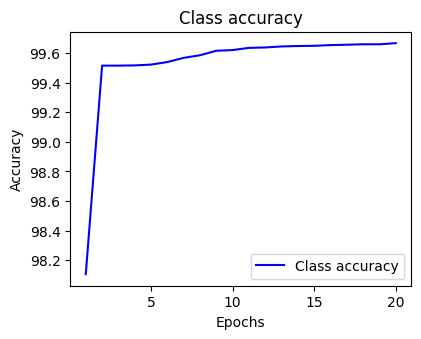

In [ ]:
set_figsize((4.4, 3.3))
plot_cls_acc(cls_acc_all)

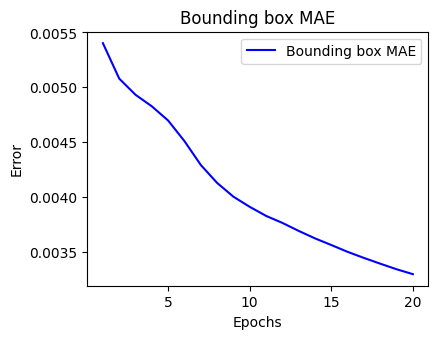

In [ ]:
plot_bbox_mae(bbox_mae_all)

During prediction,
the goal is to detect all the objects of interest
on the image.
Below
we read and resize a test image,
converting it to
a four-dimensional tensor that is
required by convolutional layers.

In [ ]:
X = torchvision.io.read_image('banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

Using the `multibox_detection` function below,
the predicted bounding boxes
are obtained
from the anchor boxes and their predicted offsets.
Then non-maximum suppression is used
to remove similar predicted bounding boxes.

In [ ]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

Finally, we display
all the predicted bounding boxes with
confidence $0.9$ or above
as output.

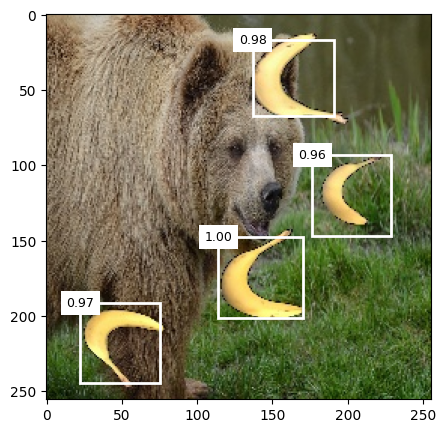

In [ ]:
def display(img, output, threshold):
    set_figsize((5, 5))
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)

# Exercises



1.   We can improve the single-shot multibox detection by improving the loss function. Replace the $\ell_1$ norm loss with the *smooth $\ell_1$ norm loss* for the predicted offsets. This loss function uses a square function around zero for smoothness, which is controlled by the hyperparameter $\sigma$:
  $$
  f(x) =
      \begin{cases}
      (\sigma x)^2/2,& \textrm{if }|x| < 1/\sigma^2\\
      |x|-0.5/\sigma^2,& \textrm{otherwise}
      \end{cases}
  $$

  When $\sigma$ is very large, this loss is similar to the $\ell_1$ norm loss. When its value is smaller, the loss function is smoother.

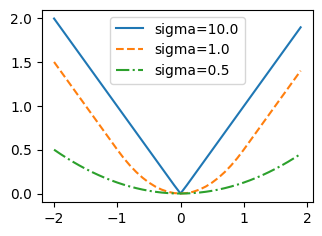

In [ ]:
def smooth_l1(data, scalar):
    out = []
    for i in data:
        if abs(i) < 1 / (scalar ** 2):
            out.append(((scalar * i) ** 2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar ** 2))
    return torch.tensor(out)

sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = torch.arange(-2, 2, 0.1)
set_figsize()

for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    plt.plot(x, y, l, label='sigma=%.1f' % s)
plt.legend();

2. In the experiment we used cross-entropy loss for class prediction:
denoting by $p_j$ the predicted probability for the ground-truth class $j$, the cross-entropy loss is $-\log p_j$. Replace the cross-entropy loss with the *focal loss*: given hyperparameter $\gamma > 0$, this loss is defined as:
  $$ - (1-p_j)^{\gamma} \log p_j.$$

  As we can see, increasing $\gamma$
  can effectively reduce the relative loss
  for well-classified examples (e.g., $p_j > 0.5$)
  so the training
  can focus more on those difficult examples that are misclassified.

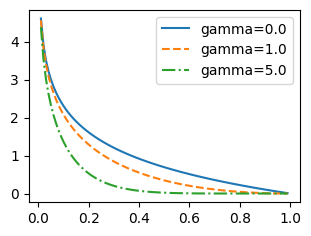

In [ ]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * torch.log(x)

x = torch.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)
plt.legend();

3. In the loss function, assign different weight hyperparameters to the class loss and the offset loss.